In [1]:
import os
os.chdir("../")

In [2]:
import pystac_client
import pystac
from requests.adapters import HTTPAdapter
from urllib3 import Retry
from pystac_client.stac_api_io import StacApiIO
import planetary_computer

import dask.distributed
import numpy as np
import rioxarray
import pandas as pd
import geopandas as gpd
from src.utils import search_s2_scenes, search_lc_scene, stack_s2_data, stack_lc_data, unique_class, missing_values, gen_chips
import yaml

In [30]:
from datetime import datetime, timedelta
import rasterio

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
with open("config.yml", "r") as file:
    config = yaml.safe_load(file)

In [6]:
aoi_gdf = gpd.read_file("data/fires/final_non_intersecting_wildfires_2015_2023.shp")

In [7]:
fire_gdf = aoi_gdf[aoi_gdf["initialdat"] > datetime(2023, 1, 1)]

In [8]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()#(n_workers=8, threads_per_worker=2)
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


2025-04-12 15:38:53,699 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 26e07aa78360d5296e08d72f74b90452 initialized by task ('rechunk-merge-rechunk-transfer-d4ab7720b642567cc4c6ccf0cb404ddb', 1, 0, 4, 0, 1, 6, 6, 0) executed on worker tcp://127.0.0.1:38887
2025-04-12 15:38:53,941 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a28a06f8783f2590b8c6e18021b98482 initialized by task ('rechunk-merge-rechunk-transfer-d4ab7720b642567cc4c6ccf0cb404ddb', 1, 0, 2, 0, 1, 6, 3, 0) executed on worker tcp://127.0.0.1:38887
2025-04-12 15:38:54,485 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 56aa2aca8dd4a17188abd7e331fa1d63 initialized by task ('rechunk-merge-rechunk-transfer-d4ab7720b642567cc4c6ccf0cb404ddb', 1, 0, 18, 0, 1, 6, 27, 0) executed on worker tcp://127.0.0.1:38887
2025-04-12 15:38:54,783 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle df45c6ca606222ccf74071203985792f initialized by task ('rechunk-merge-rechunk-transfer-d4ab7720b642567cc4

In [9]:
retry = Retry(
    total=10, backoff_factor=1, status_forcelist=[502, 503, 504], allowed_methods=None
)
stac_api_io = StacApiIO(max_retries=retry)

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

In [10]:
def nbr_threshold(s2_array):
    dnbr = dnbr(s2_array)
    nbr_threshold = xr.where(dnbr > 0.3, 1, 0)

    return nbr_threshold.nanmean()

def dnbr(s2_array):
    nbr_pre = nbr(s2_array.isel(time=0))
    nbr_post = nbr(s2_array.isel(time=1))
    dnbr = npr_pre - nbr_post
    
    return dnbr


def nbr(data):
    nbr = (data.sel(band="B08") - data.sel(band="B12")) / (data.sel(band="B08") + data.sel(band="B12"))

    return nbr


In [11]:
def process_chips(s2_stack, lc_stack, epsg, sample_size, chip_size, global_index, metadata_df):
    
    # try:
    #     lc_stack = lc_stack.compute()
    # except:
    #     print("skipping the AOI for no LC data")
    #     return global_index, metadata_df
    
    # lc_uniqueness = lc_stack.coarsen(x = sample_size,
    #                                  y = sample_size,
    #                                  boundary = "trim"
    #                                 ).reduce(unique_class)
    # lc_uniqueness[0, :] = False
    # lc_uniqueness[-1, :] = False
    # lc_uniqueness[:, 0] = False
    # lc_uniqueness[:, -1] = False

    # ys, xs = np.where(lc_uniqueness)
    # print("Loading s2_stack")
    
    try:
        s2_stack = s2_stack.compute()
    except:
        print("skipping the AOI for no S2 data")
        return global_index, metadata_df
    
    
    for index in range(0, len(ys)):
        y = ys[index]
        x = xs[index]
    
            
        x_coords = slice((x) * sample_size - int((chip_size - sample_size)/2), (x + 1) * sample_size + int((chip_size - sample_size)/2))
        y_coords = slice((y) * sample_size - int((chip_size - sample_size)/2), (y + 1) * sample_size + int((chip_size - sample_size)/2))    
        
        s2_array = s2_stack.isel(x = x_coords, y = y_coords)
        s2_array.rio.write_crs(f"epsg:{epsg}", inplace=True)
        s2_array = s2_array.where((s2_array.x >= s2_stack.x[(x) * sample_size]) &
                                  (s2_array.x < s2_stack.x[(x + 1) * sample_size]) & 
                                  (s2_array.y <= s2_stack.y[(y) * sample_size]) &
                                  (s2_array.y > s2_stack.y[(y + 1) * sample_size])
                                 )
        
        if missing_values(s2_array, chip_size, sample_size):
            # print(f"Skipping chip at index {index}")
            continue        
        
        s2_array = s2_array.fillna(-999)
        s2_array = s2_array.rio.write_nodata(-999)
        s2_array = s2_array.astype(np.dtype(np.int16))
        s2_array = s2_array.rename("s2")

        dnbr = nbr_threshold(s2_array)
        print(dnbr)

                
        lc_array = lc_stack.isel(x = x_coords, y = y_coords)
        lc_array.rio.write_crs(f"epsg:{epsg}", inplace=True)
        lc_array = lc_array.where((lc_array.x >= lc_stack.x[(x) * sample_size]) &
                                  (lc_array.x < lc_stack.x[(x + 1) * sample_size]) & 
                                  (lc_array.y <= lc_stack.y[(y) * sample_size] ) &
                                  (lc_array.y > lc_stack.y[(y + 1) * sample_size])
                                 )
        
        if missing_values(lc_array, chip_size, sample_size):
            # print(f"Skipping chip at index {index}")
            continue

        if (np.isin(lc_array, [255, 130, 133])).any():
            raise ValueError('Wrong LC value')
        
        lc_array = lc_array.fillna(0)
        lc_array = lc_array.rio.write_nodata(0)
        lc_array = lc_array.astype(np.dtype(np.int8))
        lc_array = lc_array.rename("lc")
        if (np.isin(lc_array, [7])).any():
            gen_status, dts = gen_chips(s2_array, lc_array, global_index)
            if gen_status:
                metadata_df = pd.concat([pd.DataFrame([[global_index,
                                                        dts,
                                                        np.unique(lc_array)[1],
                                                        s2_stack.x[(x) * sample_size + int(sample_size / 2)].data,
                                                        s2_stack.y[(y) * sample_size + int(sample_size / 2)].data,
                                                        epsg]
                                                      ],
                                                      columns=metadata_df.columns
                                                     ),
                                         metadata_df],
                                        ignore_index=True
                                       )
                global_index += 1
    
    return global_index, metadata_df

In [12]:
global_index = 0
metadata_df = pd.DataFrame(columns=["chip_id", "dates", "lc", "x_center", "y_center", "epsg"])
# metadata_df = pd.read_csv("../data/metadata_df.csv")

In [13]:
large_fire_gdf = fire_gdf[fire_gdf["area_ha"]>1000]

In [14]:
def get_date_ranges(row):
    pre_start_date = row["initialdat"]-timedelta(days=91)
    pre_end_date = row["initialdat"]-timedelta(days=1)

    post_start_date = row["finaldate"]+timedelta(days=1)
    post_end_date = row["finaldate"]+timedelta(days=91)

    pre_dates = f"{str(pre_start_date).split(" ")[0]}/{str(pre_end_date).split(" ")[0]}"
    post_dates = f"{str(post_start_date).split(" ")[0]}/{str(post_end_date).split(" ")[0]}"
    
    return [pre_dates, post_dates]

In [15]:
get_date_ranges(large_fire_gdf.iloc[0])

['2022-10-09/2023-01-07', '2023-01-22/2023-04-22']

In [16]:
for index, aoi in large_fire_gdf.iterrows():
    print(f"\nProcessing AOI at index {index}")
    
    aoi_bounds = aoi['geometry'].bounds
    s2_items = pystac.item_collection.ItemCollection([])
    date_ranges = get_date_ranges(aoi)
    for date_range in date_ranges:        
        s2_items_season = search_s2_scenes(aoi, date_range, catalog, config)
        s2_items += s2_items_season

    if len(s2_items)<2:
        print(f"Missing Sentinel-2 scenes for AOI {aoi_bounds}")
        continue
        

    s2_stack = stack_s2_data(s2_items, config)
    if s2_stack is None:
        print(f"Failed to stack Sentinel-2 bands for AOI {aoi_bounds}")
        continue
        
    try:
        epsg = s2_items[0].properties["proj:epsg"]
    except:
        epsg = int(s2_items[0].properties["proj:code"].split(":")[-1])
        


    # lc_items = search_lc_scene(s2_items[0].bbox, catalog, config)
    # if not lc_items:
    #     print(f"No Land Cover data found for AOI {aoi_bounds}")
    #     continue
    
    # lc_stack = stack_lc_data(lc_items, s2_stack.rio.crs.to_epsg(), s2_items[0].bbox, config)
    # if lc_stack is None:
    #     print(f"Failed to stack Land Cover data for AOI {aoi_bounds} and date range {date_range}")
    #     continue
    break
    # global_index, metadata_df = process_chips(s2_stack,
    #                                           lc_stack,
    #                                           epsg,
    #                                           config["chips"]["sample_size"],
    #                                           config["chips"]["chip_size"],
    #                                           global_index,
    #                                           metadata_df)
    # metadata_df.to_csv('/home/benchuser/data/metadata_df.csv', index=False)


Processing AOI at index 1507828
Missing Sentinel-2 scenes for AOI (-57.7797212336811, -23.254166664630308, -57.69181758804409, -23.17916666463702)

Processing AOI at index 1507873
Missing Sentinel-2 scenes for AOI (-57.49194118046381, -23.67083333125968, -57.43463281690996, -23.633333331263042)

Processing AOI at index 1507884


In [18]:
try:
    s2_stack = s2_stack.compute()
except:
    print("skipping the AOI for no S2 data")

In [23]:
clipping_geom = aoi["geometry"]

In [35]:
clipping_geom.bounds

(-58.04838553877566,
 -23.84583333124402,
 -57.93413917695026,
 -23.77083333125073)

In [48]:
clipping_geom

AttributeError: 'tuple' object has no attribute '__geo_interface__'

In [46]:
rasterio.warp.transform_geom(rasterio.crs.CRS.from_string("EPSG:4326"),
                             s2_stack.rio.crs,
                             mapping(clipping_geom.bounds))

AttributeError: 'tuple' object has no attribute '__geo_interface__'

In [43]:
s2_stack.rio.crs

CRS.from_epsg(32721)

In [53]:
clipped= s2_stack.rio.clip(
    geometries=mapping(box(*clipping_geom.bounds)),
    crs=rasterio.crs.CRS.from_string("EPSG:4326")
)

NoDataInBounds: No data found in bounds. Data variable: stackstac-92df0f6de2165c640de496ee58506203

In [55]:
s2_stack.x

<xarray.DataArray 'x' (x: 11203)> Size: 90kB
array([298460., 298470., 298480., ..., 410460., 410470., 410480.])
Coordinates: (12/17)
  * x                                        (x) float64 90kB 2.985e+05 ... 4...
    s2:high_proba_clouds_percentage          float64 8B 0.0
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    instruments                              <U3 12B 'msi'
    constellation                            <U10 40B 'Sentinel 2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    sat:orbit_state                          <U10 40B 'descending'
    s2:snow_ice_percentage                   float64 8B 0.0
    sat:relative_orbit                       int64 8B 67
    platform                                 <U11 44B 'Sentinel-2B'
    proj:bbox                                object 8B {300000.0, 409800.0, 7...
    epsg                                     int64 8B 32721

In [ ]:
[item.assets["visual"].href for item in s2_items]

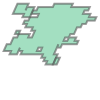

In [19]:
aoi["geometry"]

In [49]:
import json
from shapely.geometry import Polygon, mapping, box

# Define a Shapely Polygon
polygon = aoi["geometry"]

# Convert to GeoJSON format
geojson_data = {
    "type": "Feature",
    "geometry": mapping(polygon),
    "properties": {}  # You can add attributes here if needed
}

# Save to a .geojson file
with open("polygon.geojson", "w") as f:
    json.dump(geojson_data, f, indent=4)
